# DWI Workshop - Day 3 

## Constrained Spherical Deconvolution

Signal is modelled as a convolution between the response function and the fODF. Since we want to get back the fODF - we need to deconvoled the DW signal with the response function. 

Note: All commands are shown here for educational purposes. Sample scripts are available, and can be run on bluehive. 

## MRtrix3

The overall goal of CSD is to estimate the white matter fiber orientation distribution function (fODF), based on an estimated signal using deconvolution. The first step is to perform response function estimation, which is the estimated signal expected for a single-fiber white matter population. For multi-shell data, a separate response function may be estimated for WM and GM. 

#### Response function estimation. 

First you need to estimate the response functions which are used as the kernels for the deconvolution algorithm. Response functions are estimated from a voxel assumed to represent a coherent bundle of axons. For multi tissue (i.e., WM, GM) the response function may be just a number, representing the diffusivity of the expected tissue. 

In [5]:
# response function estimation 
# Don't run

#!dwi2response dhollander Data/Data/dwi.mif wm_response.txt gm_response.txt csf_response.txt

In [19]:
# This is where I keep the data locally.
# All data for these workshops can be found in the Box folder.
# https://rochester.box.com/s/91t2eb0neym1zolozqml11tejikrb8kz 

%cd /Users/afinkelstein/Documents/Projects/Data

/Users/afinkelstein/Documents/Projects/Data


In [18]:
!shview wm.txt
!shview gm.txt
!shview csf.txt

#### MSMT-CSD

Once you have estimated the response functions using dwi2response, then you will perform deconvolution to estimate the fODF.

<p align='center'>
  <img src ="images/CSD.jpg" alt='fodf' width=500/>
</p>

<p align='center'>
  <img src ="images/Sphericalfunctions.png" alt='fodf' width=500/>
</p>

In [20]:
# MSMT-CSD
# Don't run 

#!dwi2fod msmt_csd dwi_preproc.mif -mask BrainMask.nii.gz wm.txt wmfod.mif gm.txt gmfod.mif csf.txt csffod.mif
#!mrconvert -coord 3 0 "${ROOT}/wmfod.mif" - | mrcat "${ROOT}/csffod.mif" "${ROOT}/gmfod.mif" - "${ROOT}/vf.mif" -force

In [21]:
!mrview vf.mif -odf.load_sh wmfod.mif

In [22]:
!mrview vf.mif -odf.load_sh gmfod.mif

In [23]:
# Tissue Normalization: normalize tissue components from MT-CSD and outputs normalized 
# tissue components corrected for intensity inhomogeneities. 

#!mtnormalise "${ROOT}/wmfod.mif" "${ROOT}/wmfod_norm.mif" "${ROOT}/gmfod.mif" \
#"${ROOT}/gmfod_norm.mif" "${ROOT}/csffod.mif" "${ROOT}/csffod_norm.mif" -mask "${ROOT}/${DWI_ROOT}_BrainMask.nii.gz"

In [25]:
# Set seed 
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np 

In [40]:
# Run 5ttgen or FAST in FSL to segment tissues. 

img = nib.load('5tt_coreg.nii.gz').get_fdata()

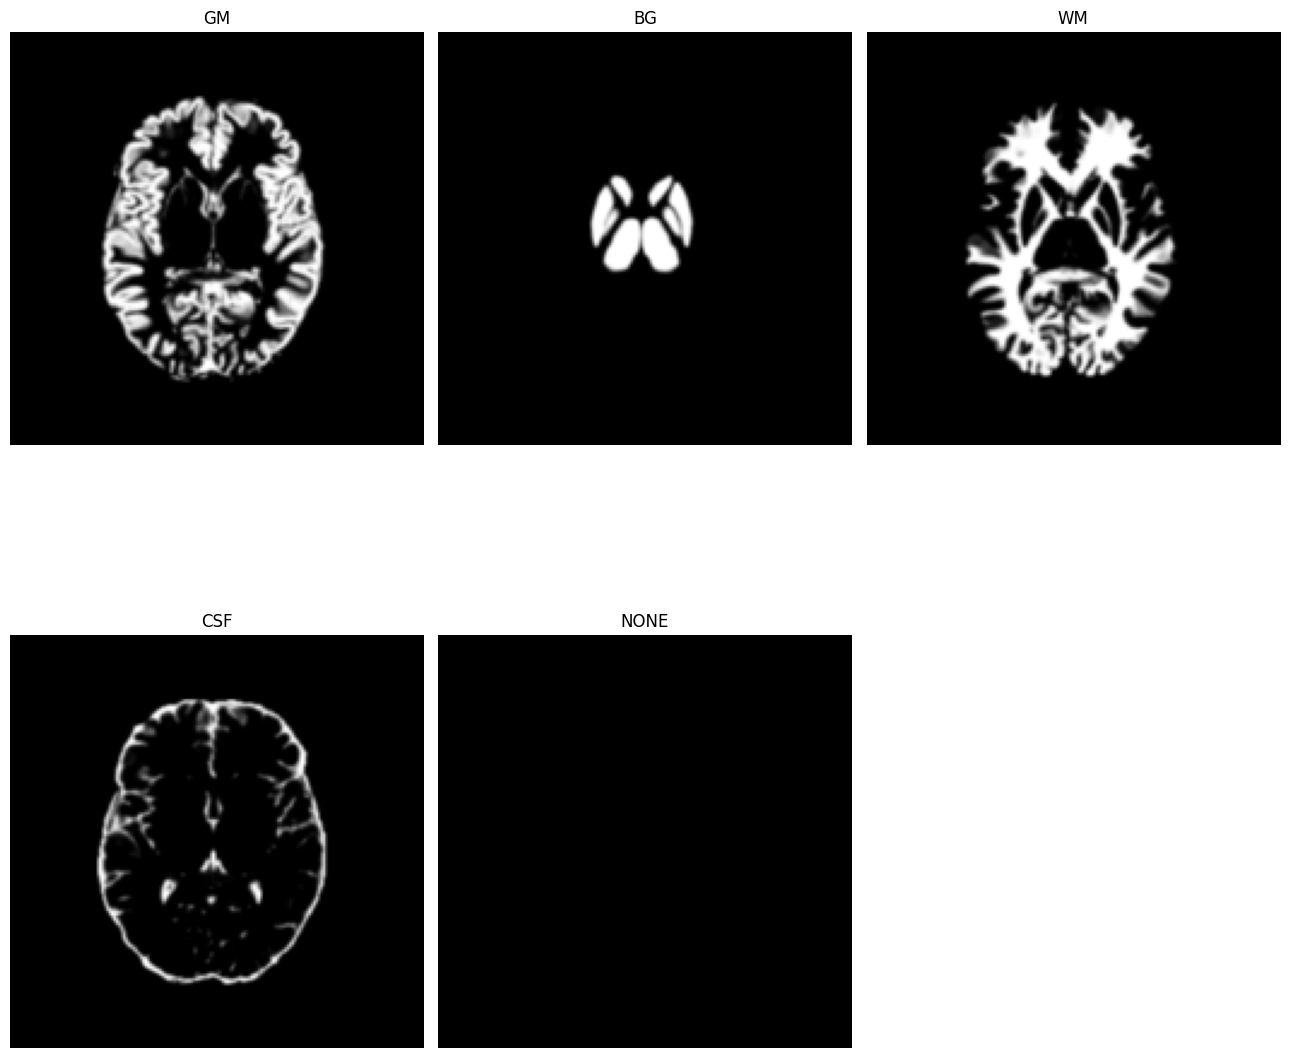

In [45]:
plt.figure(figsize=(13,13))
tissues = ['GM', 'BG', 'WM', 'CSF', 'NONE']
for i in range(img.shape[-1]):
    plt.subplot(2,3,i+1)
    plt.imshow(np.rot90(img[:,:,50, i]), cmap='gray')
    plt.title(tissues[i])
    plt.axis('off')
plt.tight_layout()

In [43]:
#Create GM/WM interface 

# 5tt2gmwmi 5tt_coreg.nii.gz gmwmSeed_coreg.mif

In [44]:
!mrview gmwmSeed_coreg.mif

#### Tractography

Using the GMWM interface as a seed we will now perform probabilistic tractography. 


<p align='center'>
  <img src ="images/probtracks.png" alt='probtrack' width=500/>
</p>


In [71]:
!mrview T1_coreg_diff.nii.gz -tractography.load smallerTracks_200k.tck -plane 0 -mode 3 -imagevisible false

#### SIFT 

You have now created a tractogram for a single subject. Connectivity analysis may now be performed based on fiber count as discussed in the next section.